## **Imports**

In [1]:
import os
import librosa
import numpy as np
import soundfile

import torch
from torch import nn

## **Dataset loading and preprocessing** 

 Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/ and unzip it to ./dataset

We took a look at the dataset, and because it has only 1 sec audio files, we decided to combine them into a single piece, so we can work easier with it.

In [2]:
import shutil

# Path to the folder where the combined recordings will be saved
combined_output_path = "./combined_recordings"
cut_output_path = "./dataset/"


os.makedirs(combined_output_path, exist_ok=True)

# Label of the speakers in the dataset
speaker_names = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

audio_folder = "audio"
noise_subfolder = "noise"
dataset_audio_path = os.path.join(cut_output_path, audio_folder)
dataset_noise_path = os.path.join(cut_output_path, noise_subfolder)

noise_folders = ["./dataset/other", "./dataset/_background_noise_"]

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for folder in os.listdir(cut_output_path):
    full_path = os.path.join(cut_output_path, folder)
    
    if full_path == os.path.join(cut_output_path, audio_folder):
        break
    
    if not os.path.isdir(full_path):
        continue
    #for folder1 in os.listdir(full_path):
    if full_path in noise_folders:
        destination = os.path.join(dataset_noise_path, folder)
    else:
        destination = os.path.join(dataset_audio_path, folder)
    shutil.move(full_path, destination)

In [3]:
# Combined recording length in seconds
full_recording_length = 60

# Iterate over all speakers
for speaker in speaker_names:
    # Get the speaker folder name
    speaker_folder_path = os.path.join(cut_output_path, audio_folder, speaker)

    # Combine all WAV files into a single long file
    combined_audio = []
    for i in range(full_recording_length):
        audio_file_path = os.path.join(speaker_folder_path, f"{i}.wav")
        audio, sampling_rate = librosa.load(audio_file_path, sr=None)
        combined_audio.extend(audio)

    # Save the combined audio file
    output_file_path = os.path.join(combined_output_path, f"{speaker}.wav")
    soundfile.write(output_file_path, combined_audio, sampling_rate)

Reorganize folder data

## Understanding the data

In order to see that we combined the audio files correctly we want to hear the audio file. 
We can do this using the IPython.display.Audio function.

In [4]:
from IPython.display import display, Audio

display(Audio(filename=".\combined_recordings\Benjamin_Netanyau.wav"))


### Visualization

In order to see how noisy the data is, we will use the `matplotlib.pyplot` and `librosa` library to load an audio file, create a waveform plot, and display it.

In [5]:
import matplotlib.pyplot as plt

# Path to the combined audio file for the speaker
audio_file_path = "./combined_recordings/Benjamin_Netanyau.wav"

# Load the audio file, only the first 10 seconds for faster loading
audio, sampling_rate = librosa.load(audio_file_path, duration=10)

#TODO: Explain what a waveform is

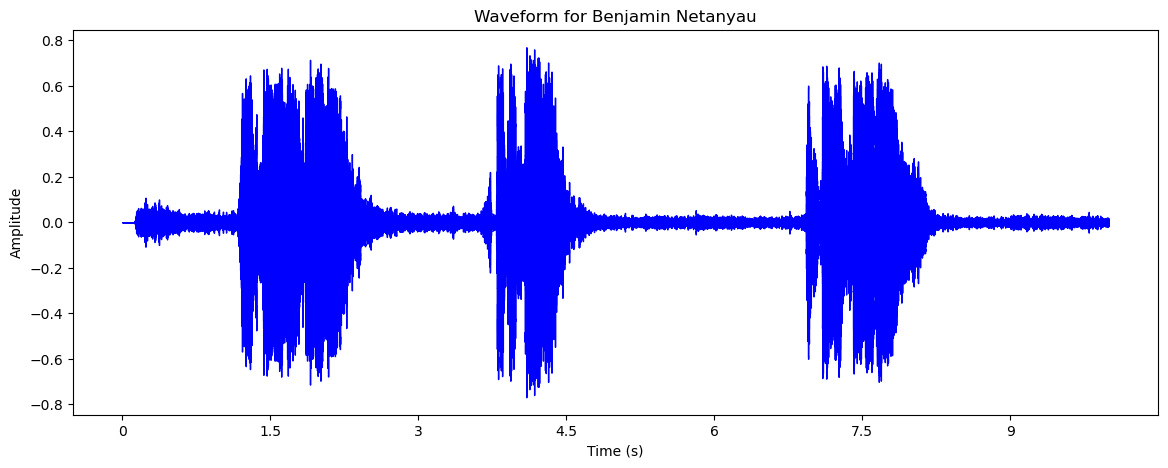

In [6]:
# Create the waveform plot
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sampling_rate, color="blue")
plt.title("Waveform for Benjamin Netanyau")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


# Spectrogram
A spectrogram is a two-dimensional graph that visualizes the variation of signal strength or sound level over time. The x-axis of the graph represents time, and the y-axis represents frequency. Additionally, the third dimension can be interpreted through the various colors observed in the graph. The colors correspond to the sound volume (amplitude) in the graph, where dark blue indicates a low sound volume, and the lighter colors, with red being the highest, indicate a high sound volume. Therefore, one can analyze both how energy varies over time and the amount of energy present at different frequencies in the graph.

In our code, we generate the spectrogram to then extract mel-frequency cepstral coefficients (MFCC), which is a set of coefficient representing the  spectral characteristics of an audio signal.

1. **Spectrogram Generation:**
   First, the spectrogram for the audio signal is computed. The spectrogram illustrates the frequency content of the sound over time.

2. **Mel-filterbank:**
   A filterbank with mel filters is used to create a mel scale, which is a perceptually based scale across the frequency range. This filterbank covers various areas in the frequency spectrum, where the filters are more concentrated at lower frequencies.

3. **Logarithmic Transformation:**
   Logarithmic transformation is applied to the spectrum from the filterbank to align with the non-linear response of the human ear to sound intensity.

4. **Discrete Cosine Transform (DCT):**
   Discrete Cosine Transform is applied to the logarithmic energies to obtain MFCC. DCT transforms the information from the frequency domain to the cepstral domain.

5. **MFCC Coefficients:**
   The resulting coefficients are the MFCC representing the short-term frequency information of the audio signal.



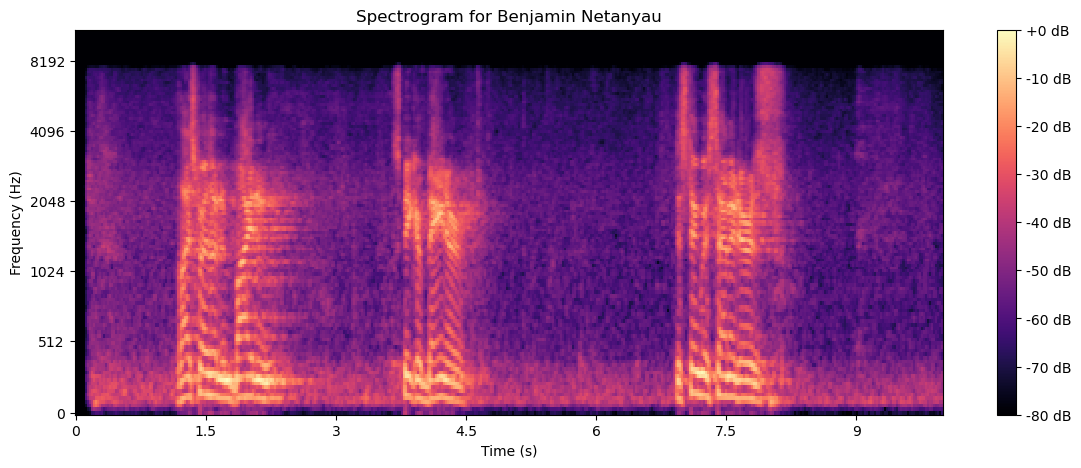

In [7]:
# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate)

# Convert to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram for Benjamin Netanyau')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


## Feature extraction

Before we can train our model, first, we have to extract important features from our audio files.

In [8]:
# Define the directory where your audio files are


features = []
labels = []

for folder in os.listdir(os.path.join(cut_output_path, audio_folder)):
    full_path = os.path.join(cut_output_path, audio_folder, folder)
    for filename in os.listdir(full_path):
        if filename.endswith('.wav'):
            audio_file_path = os.path.join(full_path, filename)
            audio, sample_rate = librosa.load(audio_file_path, sr=None)
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=10) # TODO: Try experimenting with n_mfcc
            
            features.append(mfccs.T)    
            
            speaker_name = folder.replace('_', ' ')
            
            # Append the speaker name to the labels list
            labels.append(speaker_name)
        
features = np.array(features)
labels = np.array(labels)


In [9]:
print(f"Number of training samples: {features.shape}")
print(f"Number of labels: {labels.shape}")

# Print the number of features extracted for the first audio file
first_feature_vector = features[0]
num_features = sum([len(feature.flatten()) for feature in first_feature_vector])
print(f"Number of features extracted for the first audio file: {num_features}")

Number of training samples: (7501, 32, 10)
Number of labels: (7501,)
Number of features extracted for the first audio file: 320


## Model Training

In [10]:
# Import necessary libraries
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Encode labels using explicit classes
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
encoder.classes_ = np.array(speaker_names)

# Split the data into training, validation, and test sets
random_seed = 42
features_train, features_temp, labels_train, labels_temp = train_test_split(
    features, labels, test_size=0.3, random_state=random_seed
    )
features_val, features_test, labels_val, labels_test = train_test_split(
    features_temp, labels_temp, test_size=0.5, random_state=random_seed
    )


# Function to convert data to PyTorch tensors and create a DataLoader
def create_dataloader(features, labels, batch_size):
    # Convert the data to PyTorch tensors
    features_tensor = torch.tensor(features).float()
    labels_tensor = torch.tensor(labels).long()

    # Create a DataLoader
    dataset = TensorDataset(features_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# Create DataLoader for training
train_loader = create_dataloader(features_train, labels_train, batch_size=32)

# Create DataLoader for testing
test_loader = create_dataloader(features_test, labels_test, batch_size=32)

# Create DataLoader for validation
val_loader = create_dataloader(features_val, labels_val, batch_size=32)

# Print the shapes of training and validation data
print("Training Data Shape:", features_train.shape)
print("Validation Data Shape:", features_val.shape)
print("Labels shape", labels.shape)

Training Data Shape: (5250, 32, 10)
Validation Data Shape: (1125, 32, 10)
Labels shape (7501,)


In [11]:
import numpy as np
import tqdm

criterion = nn.CrossEntropyLoss()

def get_accuracy(preds, y):
     
    """ 
    Calculate accuracy given predictions and ground truth labels.

    Args:
        preds (torch.Tensor): Model predictions.
        y (torch.Tensor): Ground truth labels.

    Returns:
        float: Accuracy.
    """
    _, predicted = torch.max(preds.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct / total

def loop_vm(net, loader, opt, is_train, epoch):
    """
    Training/validation loop for a neural network.

    Args:
        net (torch.nn.Module): Neural network model.
        loader (torch.utils.data.DataLoader): Data loader.
        opt (torch.optim.Optimizer): Optimizer.
        is_train (bool): Flag indicating whether it is a training phase.
        epoch (int): Current epoch.

    Returns:
        Prints out the values 
    """
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm.tqdm(loader, total=len(loader))
    mode = "Training" if is_train else "Validation"
    
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = criterion(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc)
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        pbar.set_description(f'{mode}: Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')


In [12]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Custom LSTM-based neural network model.

        Args:
            input_size (int): Number of features in the input data.
            hidden_size (int): Number of features in the hidden state of the LSTM.
            output_size (int): Number of output classes.
        """
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Output of the neural network.
        """
        out, _ = self.lstm(x)  # Ignore the hidden state, only take the output
        out = torch.relu(out[:, -1, :])  # Take the last output for each sequence
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Get the number of features from the shape of the training data
num_features = features_train.shape[-1]

# Instantiate the model
model = MyModel(num_features, 128, len(speaker_names)).to(device)

# Instantiate the Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(10):
    # Train the model on the training set
    loop_vm(model, train_loader, optimizer, True, epoch)
    # Evaluate the model on the validation set
    loop_vm(model, val_loader, optimizer, False, epoch)

Validation: Epoch: 10 Loss: 0.0120 Acc: 0.9948: 100%|██████████| 36/36 [00:00<00:00, 174.32it/s]


Number of true posetive 1119 and number of false posetive 7 


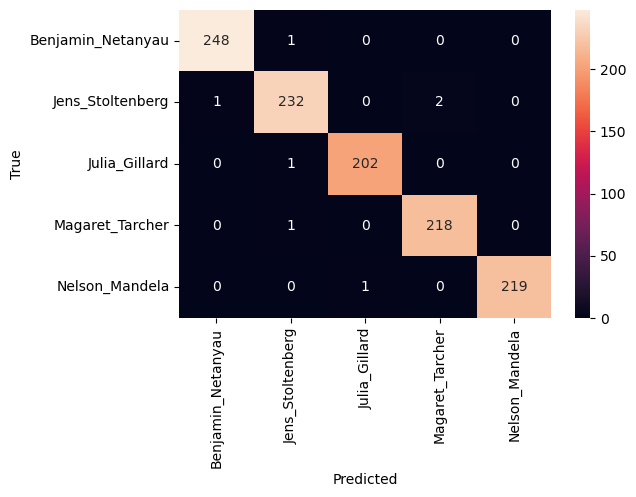

In [22]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns

def evaluate_model(net, loader):
    """
    Evaluate the performance of a neural network model on a test dataset.

    Args:
        net (torch.nn.Module): Neural network model.
        loader (torch.utils.data.DataLoader): Test data loader.

    Returns:
        tuple: Test accuracy, precision, recall, and confusion matrix.
    """
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = net(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    false_posetive=total-correct       
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return correct, false_posetive, accuracy, precision, recall, conf_matrix

# Evaluate the model on the test dataset
correct, false_posetive, test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(model, test_loader)
print(f"Number of true posetive {correct} and number of false posetive {false_posetive} ")
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=speaker_names, yticklabels=speaker_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Test Verification System

In [14]:
import torchaudio

def verify_speaker(model, sound_file, claimed_speaker_name):

    """
    Verify the claimed speaker identity using a trained speaker verification model.

    Args:
        model (torch.nn.Module): Trained speaker verification model.
        sound_file (str): Path to the sound file for verification.
        claimed_speaker_name (str): Claimed identity of the speaker.
    """
    # Load the sound file
    waveform, sample_rate = torchaudio.load(sound_file)

    # Extract MFCC features from the audio
    features = []
    audio, sample_rate = librosa.load(sound_file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=10) # TODO: Try experimenting with n_mfcc     
    features.append(mfccs.T)
    features = np.array(features)

    # Move the features to the device
    #features = features.to(device)

    # Use the model to predict the speaker
    model.eval()
    with torch.no_grad():
        features_tensor = torch.tensor(features).float().to(device)  # Move the tensor to the GPU
        preds = model(features_tensor)
        _, predicted = torch.max(preds.data, 1)        
        # Get the predicted speaker name
    predicted_speaker_name = encoder.inverse_transform(predicted.cpu().numpy())

    # Check if the predicted speaker name matches the claimed speaker name
    if predicted_speaker_name == claimed_speaker_name:
        print("The claim is verified. The speaker is indeed", claimed_speaker_name)
    else:
        print("The claim is not verified. The speaker is not", claimed_speaker_name)
        

# Example: Use the function to verify a speaker
verify_speaker(model, os.path.join(dataset_audio_path, speaker_names[0], "1.wav"), speaker_names[0])

The claim is verified. The speaker is indeed Benjamin_Netanyau


## TODO: 

1. Write explanations to each important thing. 
2. Use another dataset. -> a bit laborious
3. Improve code.
4. Write metrics of corectness for Biometrics. 
5. Create the report.  -> a bit laborious
6. Create another model.
7. Record your own audio. 
8. Record with Microphone and test if the speaker is the one that it claims to be. 
9. Create a simple aplications for recording and live demo. 

## Concultion 

# Refrences 
https://pnsn.org/spectrograms/what-is-a-spectrogram 

https://vtiya.medium.com/mfcc-vs-mel-spectrogram-8f1dc0abbc62

